# Grad-CAM to visualise where the CNN is looking
-----

#### Initial Setup
---


In [0]:
## Connecting google drive to colab

!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

fuse: mountpoint is not empty
fuse: if you are sure this is safe, use the 'nonempty' mount option


In [0]:
import keras
from keras.datasets import cifar10
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, Flatten, Input, AveragePooling2D, merge, Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import Concatenate
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [0]:
import keras.backend as K
import numpy as np
import cv2
import sys

from matplotlib import pyplot as plt
%matplotlib inline

In [0]:
# this part will prevent tensorflow to allocate all the avaliable GPU Memory
# backend
import tensorflow as tf
from keras import backend as k

# Don't pre-allocate memory; allocate as-needed
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

# Create a session with the above options specified.
k.tensorflow_backend.set_session(tf.Session(config=config))

### Load CIFAR10 Data
---------


In [0]:
num_classes = 10

# Load CIFAR10 Data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
img_height, img_width, channel = x_train.shape[1],x_train.shape[2],x_train.shape[3]

# convert to one hot encoding 
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [0]:
"""
Labels of class index:

airplane : 0
automobile : 1
bird : 2
cat : 3
deer : 4
dog : 5
frog : 6
horse : 7
ship : 8
truck : 9

"""

CLASS_LABELS = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

### Create Model and Load Weights
----

My DenseNet model of Assignment 4 is used.

In [0]:
# Hyperparameters
batch_size = 32
num_classes = 10
epochs = 50
l = 40
num_filter = 24
compression = 0.5
dropout_rate = 0.2

In [0]:
# Dense Block
def add_denseblock(input, num_filter = 12, dropout_rate = 0.2):
    global compression
    temp = input
    for _ in range(l):
        BatchNorm = BatchNormalization()(temp)
        relu = Activation('relu')(BatchNorm)
        Conv2D_3_3 = Conv2D(int(num_filter*compression), (3,3), use_bias=False ,padding='same')(relu)
        if dropout_rate>0:
          Conv2D_3_3 = Dropout(dropout_rate)(Conv2D_3_3)
        concat = Concatenate(axis=-1)([temp,Conv2D_3_3])
        
        temp = concat
        
    return temp

In [0]:
def add_transition(input, num_filter = 12, dropout_rate = 0.2):
    global compression
    BatchNorm = BatchNormalization()(input)
    relu = Activation('relu')(BatchNorm)
    Conv2D_BottleNeck = Conv2D(int(num_filter*compression), (1,1), use_bias=False ,padding='same')(relu)
    if dropout_rate>0:
      Conv2D_BottleNeck = Dropout(dropout_rate)(Conv2D_BottleNeck)
    avg = AveragePooling2D(pool_size=(2,2))(Conv2D_BottleNeck)
    
    return avg

In [0]:
def output_layer(input):
    global compression
    BatchNorm = BatchNormalization()(input)
    relu = Activation('relu')(BatchNorm)
    AvgPooling = AveragePooling2D(pool_size=(2,2))(relu)
    flat = Flatten()(AvgPooling)
    output = Dense(num_classes, activation='softmax')(flat)
    
    return output

In [0]:
num_filter = 24
dropout_rate = 0.2
l = 40
input = Input(shape=(img_height, img_width, channel,))
BatchNormInit = BatchNormalization()(input)
reluInit = Activation('relu')(BatchNormInit)
First_Conv2D = Conv2D(num_filter, (3,3), use_bias=False ,padding='same')(reluInit)

First_Block = add_denseblock(First_Conv2D, num_filter, dropout_rate)
First_Transition = add_transition(First_Block, num_filter, dropout_rate)

Second_Block = add_denseblock(First_Transition, num_filter, dropout_rate)
Second_Transition = add_transition(Second_Block, num_filter, dropout_rate)

Third_Block = add_denseblock(Second_Transition, num_filter, dropout_rate)
Third_Transition = add_transition(Third_Block, num_filter, dropout_rate)

Last_Block = add_denseblock(Third_Transition,  num_filter, dropout_rate)
output = output_layer(Last_Block)


In [0]:
model = Model(inputs=[input], outputs=[output])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
batch_normalization_166 (BatchN (None, 32, 32, 3)    12          input_2[0][0]                    
__________________________________________________________________________________________________
activation_166 (Activation)     (None, 32, 32, 3)    0           batch_normalization_166[0][0]    
__________________________________________________________________________________________________
conv2d_165 (Conv2D)             (None, 32, 32, 24)   648         activation_166[0][0]             
__________________________________________________________________________________________________
batch_norm

In [0]:
# determine Loss function and Optimizer
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

In [0]:
model.load_weights("drive/GradCam/DNSTWeightsEpoch50-0.9295tranacc-0.81valacc.h5")

### Generate Predictions from Test Data
---


In [0]:
predictions = model.predict(x_test)

In [0]:
class_idx = np.argmax(predictions, axis=1) #axis=1 for row wise max
class_idx = np.reshape(class_idx, (len(class_idx),1))

In [0]:
y_test_idx = np.argmax(y_test, axis=1) #axis=1 for row wise max
y_test_idx = np.reshape(y_test_idx, (len(class_idx),1))

In [0]:
print(f"Number of correct predictions: {np.count_nonzero(y_test_idx == class_idx)}")
print(f"Accuracy: {(np.count_nonzero(y_test_idx == class_idx)/len(class_idx))*100.0}")

Number of correct predictions: 8633
Accuracy: 86.33


In [0]:
#Indexes of misclassified output
misclassified_images_index = np.argwhere((y_test_idx == class_idx) == False)[:,0]

Predicted Class: deer - Correct Class: cat


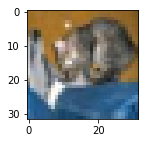

In [0]:
print(f"Predicted Class: {CLASS_LABELS[class_idx[misclassified_images_index[0]][0]]} - Correct Class: {CLASS_LABELS[int(y_test_idx[misclassified_images_index[0]][0])]}")
fig, ax = plt.subplots(figsize=(2, 2))
ax.imshow(x_test[0], aspect='auto')

## Analysis of model using GradCam
-----

In [0]:
max_misclassified_imgs = 50
last_conv_layer = model.get_layer("activation_330")

### Using GradCAM to check misclassified images
---------


#### Misclassified Images with focus on heatmaps

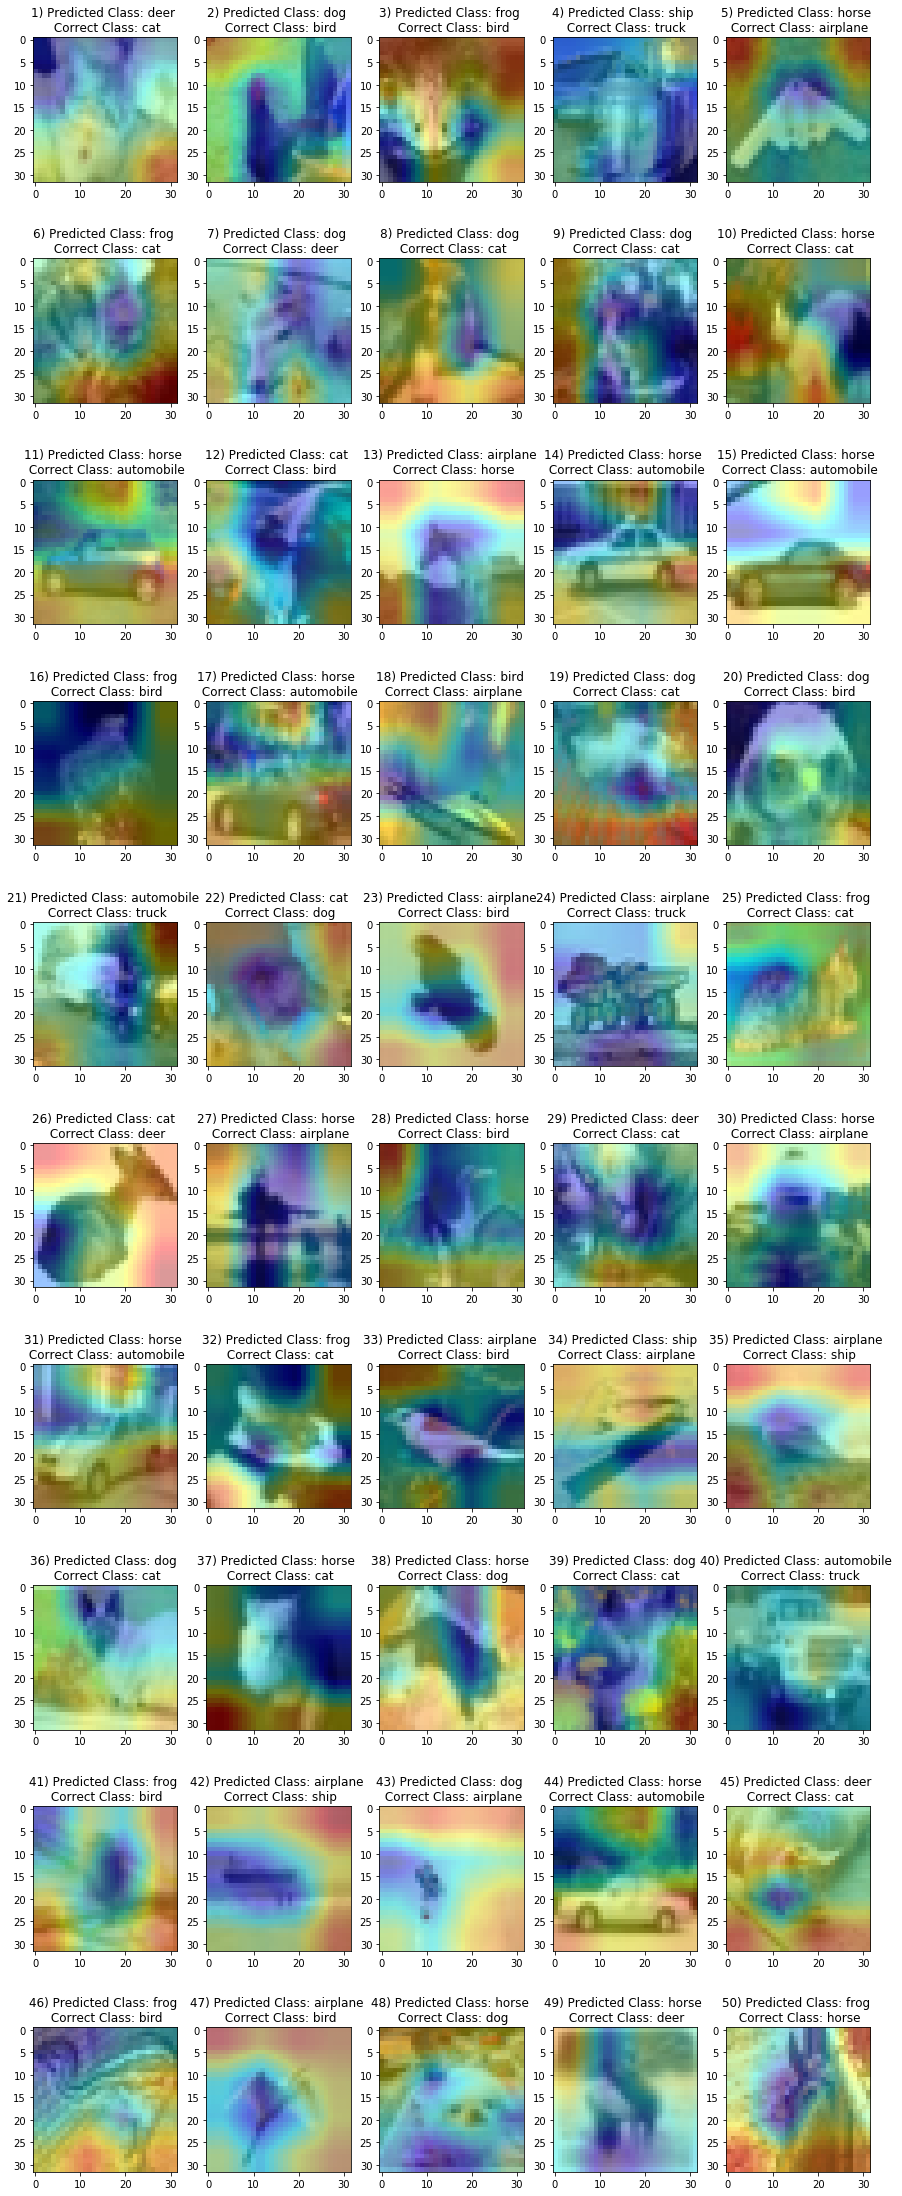

In [0]:
fig=plt.figure(figsize=(15, 40))
#fig.subplots_adjust(wspace = 0.9)
columns = 5
rows = 10
ind = 1

for mis_index in range(max_misclassified_imgs):
  index = misclassified_images_index[mis_index]
  class_output = model.output[:, int(y_test_idx[index][0])]
  
  grads = K.gradients(class_output, last_conv_layer.output)[0]
  pooled_grads = K.mean(grads, axis=(0, 1, 2))
  iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
  pooled_grads_value, conv_layer_output_value = iterate([np.expand_dims(x_test[index], axis=0)])
  for i in range(256):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
  
  heatmap = np.mean(conv_layer_output_value, axis=-1)
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)
  
  img = x_test[index]
  heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
  heatmap = np.uint8(255 * heatmap)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
  superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)
  
  a = fig.add_subplot(rows, columns, ind)
  
  plt.imshow(img)
  plt.imshow(superimposed_img)
  
  a.set_title(f"{mis_index+1}) Predicted Class: {CLASS_LABELS[class_idx[index][0]]} \n Correct Class: {CLASS_LABELS[int(y_test_idx[index][0])]}")
  
  ind = ind + 1

plt.show()

#### Misclassified Images with better resolution

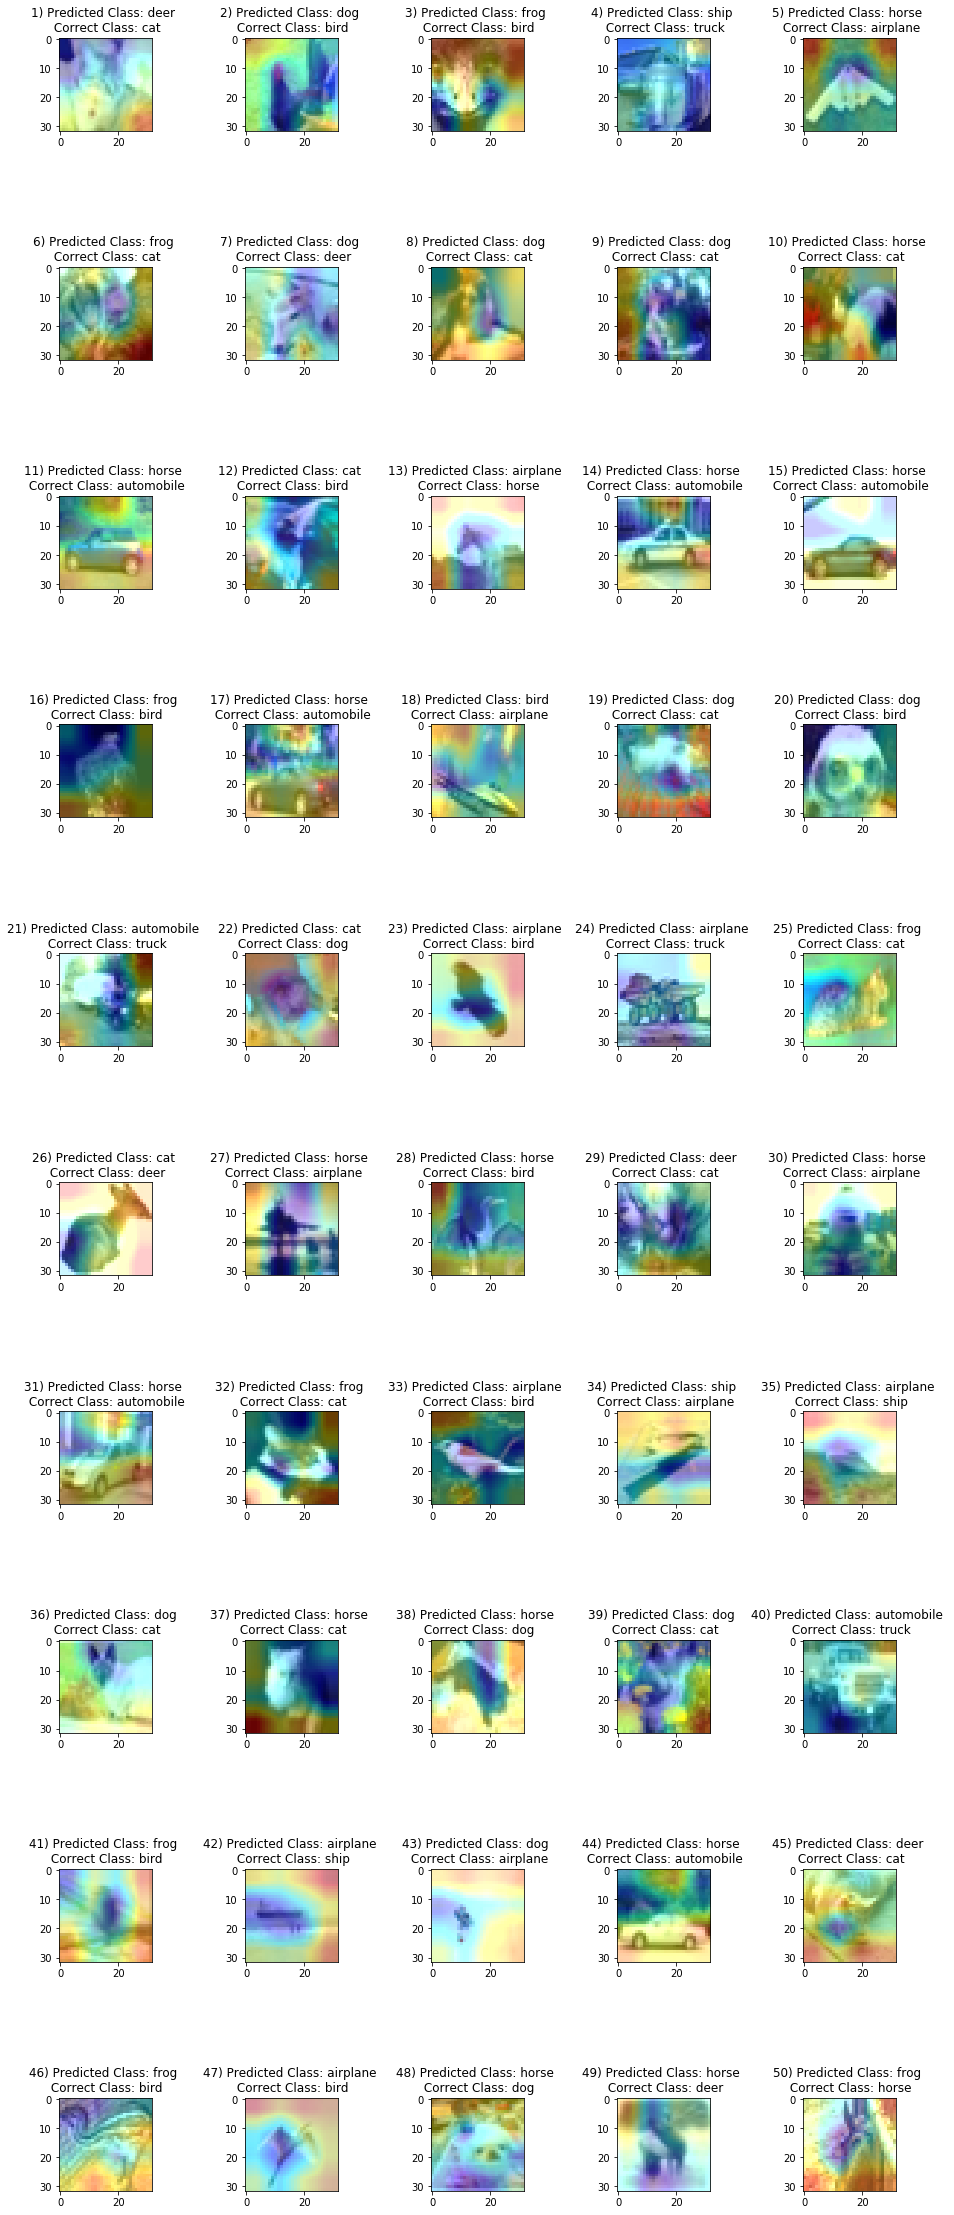

In [0]:
fig=plt.figure(figsize=(15, 40))
fig.subplots_adjust(wspace = 1, hspace = 1)
columns = 5
rows = 10
ind = 1

for mis_index in range(max_misclassified_imgs):
  index = misclassified_images_index[mis_index]
  class_output = model.output[:, int(y_test_idx[index][0])]
  
  grads = K.gradients(class_output, last_conv_layer.output)[0]
  pooled_grads = K.mean(grads, axis=(0, 1, 2))
  iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
  pooled_grads_value, conv_layer_output_value = iterate([np.expand_dims(x_test[index], axis=0)])
  for i in range(256):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
  
  heatmap = np.mean(conv_layer_output_value, axis=-1)
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)
  
  img = x_test[index]
  heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
  heatmap = np.uint8(255 * heatmap)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
  superimposed_img = cv2.addWeighted(img, 0.8, heatmap, 0.4, 0)
  
  a = fig.add_subplot(rows, columns, ind)
  
  #plt.figure(figsize=(1,1))
  plt.imshow(img)
  plt.imshow(superimposed_img)
  
  a.set_title(f"{mis_index+1}) Predicted Class: {CLASS_LABELS[class_idx[index][0]]} \n Correct Class: {CLASS_LABELS[int(y_test_idx[index][0])]}")
  
  ind = ind + 1

plt.show()

In [0]:
from matplotlib import pyplot as pyplt

for mis_index in range(max_misclassified_imgs):
  index = misclassified_images_index[mis_index]
  class_output = model.output[:, int(y_test_idx[index][0])]
  
  grads = K.gradients(class_output, last_conv_layer.output)[0]
  pooled_grads = K.mean(grads, axis=(0, 1, 2))
  iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
  pooled_grads_value, conv_layer_output_value = iterate([np.expand_dims(x_test[index], axis=0)])
  for i in range(256):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
  
  heatmap = np.mean(conv_layer_output_value, axis=-1)
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)
  
  img = x_test[index]
  heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
  heatmap = np.uint8(255 * heatmap)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
  superimposed_img = cv2.addWeighted(img, 0.8, heatmap, 0.4, 0)
  
  pyplt.figure(figsize=(1,1))
  pyplt.imshow(img)
  pyplt.imshow(superimposed_img)
  
  pyplt.savefig("drive/GradCam/MisclassifiedImages/" + f"img {mis_index+1} - Original: {CLASS_LABELS[int(y_test_idx[index][0])]}- Predicted: {CLASS_LABELS[class_idx[index][0]]}.png")

print("Saved Images to Drive")

Saved Images to Drive


### Analysing sample misclassified test data
---



Reusable function to view GradCAM result on each image:

In [0]:
def show_single_img_gradcam_res(mis_index):
  index = misclassified_images_index[mis_index]
  class_output = model.output[:, int(y_test_idx[index][0])]

  grads = K.gradients(class_output, last_conv_layer.output)[0]
  pooled_grads = K.mean(grads, axis=(0, 1, 2))
  iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
  pooled_grads_value, conv_layer_output_value = iterate([np.expand_dims(x_test[index], axis=0)])
  for i in range(256):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

  heatmap = np.mean(conv_layer_output_value, axis=-1)
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)

  img = x_test[index]
  heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
  heatmap = np.uint8(255 * heatmap)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
  superimposed_img = cv2.addWeighted(img, 0.4, heatmap, 0.4, 0)

  fig, ax = plt.subplots(figsize=(2, 2))
  ax.imshow(img)
  ax.imshow(superimposed_img)
  ax.set_title(f"{mis_index+1}) Predicted Class: {CLASS_LABELS[class_idx[index][0]]} \n Correct Class: {CLASS_LABELS[int(y_test_idx[index][0])]}")

Sample 1:

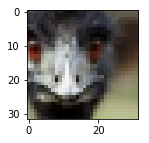

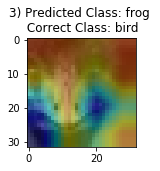

In [0]:
miss_index = 2
fig1, ax1 = plt.subplots(figsize=(2, 2))
ax1.imshow(x_test[misclassified_images_index[miss_index]], aspect='auto')
show_single_img_gradcam_res(miss_index)

From the above image, we can see that the last convolution layer of the model is focusing on the mouth portion of the bird which is similar to that of a frog's. So, its predicting it as frog. Had it focused on the entire face which is slightly askew from the center, the prediction would have been correct. 


Sample 2:

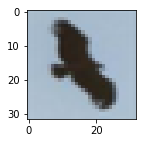

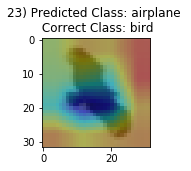

In [0]:
miss_index = 22
fig1, ax1 = plt.subplots(figsize=(2, 2))
ax1.imshow(x_test[misclassified_images_index[miss_index]])
show_single_img_gradcam_res(miss_index)

From the above image, we can see that the last convolution layer of the model is focusing on the center portion of the image which is similar to an airplane viewed from bottom.  


### Conclusion
---

1) The model seems to biased towards focusing at the center of the image.

2) The data does not seem to cover every orientation of each class. So, image augmentation can improve the model.

3) Also, due to the small size of the image, the model seems to have suffered as can be seen from unclear and blurry resolution of the image. Super resolution can further improve the **accuracy** of the model.